---
# Optimal Region Selection for New Oil Well Development

This project aims to identify the most profitable and least risky region for developing new oil wells among three potential regions. Using advanced data analysis techniques and machine learning models, we assess each region's potential by analyzing geological data, predicting oil reserves, and evaluating financial metrics.
Our approach involves several key steps:

- Data Preparation: We begin by loading and inspecting the geological data from the three regions to understand its structure and ensure its readiness for analysis.
- Model Training and Validation: We train a Linear Regression model to predict the volume of oil reserves, using a split of training and validation data to ensure model accuracy. Performance metrics such as average predicted volume and Root Mean Squared Error (RMSE) are calculated for each region.
- Profit Calculation Preparation: Key financial parameters are established, and we calculate the minimum volume of reserves required to avoid losses. These values are compared with the average reserves in each region.
- Profit Analysis from Selected Wells: We select the top 200 wells with the highest predicted values in each region and calculate the total volume of reserves and expected profit.
- Risk and Profit Assessment: Employing the bootstrapping technique, we analyze the distribution of profits for each region, determining the average profit, confidence intervals, and the risk of losses.

The final recommendation is based on a comprehensive comparison of expected profits and associated risks.

---

###  Data Loading and Initial Inspection
#### Loading data from the three CSV files 

In [1]:
# Import all necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from scipy.stats import bootstrap
import matplotlib.pyplot as plt

# Load CSV files
data_region_0 = pd.read_csv('geo_data_0.csv')
data_region_1 = pd.read_csv('geo_data_1.csv')
data_region_2 = pd.read_csv('geo_data_2.csv')

# Inspecting first 5 rows of each dataset
display(data_region_0.head())
display(data_region_1.head())
display(data_region_2.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


#### Inspecting each dataset

In [2]:
# Inspecting the datasets
print("Dataset Information:")
print(data_region_0.info())
print(data_region_1.info())
print(data_region_2.info())

# Summary statistics
print("Summary Statistics:")
display(data_region_0.describe())
display(data_region_1.describe())
display(data_region_2.describe())

# Check for missing values
print("Missing Values:")
display(data_region_0.isnull().sum())
display(data_region_1.isnull().sum())
display(data_region_2.isnull().sum())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   id       100000 non-null  object 
 1   f0       100000 non-null  float64
 2   f1       100000 non-null  float64
 3   f2       100000 non-null  float64
 4   product  100000 non-null  float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 co

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


Missing Values:


id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

id         0
f0         0
f1         0
f2         0
product    0
dtype: int64

#### Check For Duplicates

In [3]:
# Check for completely duplicated rows in each dataframe
print(f"Region 0 duplicated rows: {data_region_0.duplicated().sum()}")
print(f"Region 1 duplicated rows: {data_region_1.duplicated().sum()}")
print(f"Region 2 duplicated rows: {data_region_2.duplicated().sum()}")

# Check for duplicates in each column of each dataframe
duplicates_region_0 = data_region_0.apply(lambda x: x.duplicated().sum())
duplicates_region_1 = data_region_1.apply(lambda x: x.duplicated().sum())
duplicates_region_2 = data_region_2.apply(lambda x: x.duplicated().sum())

# Print duplicate counts per column for each dataframe
print("Duplicates in Region 0:")
print(duplicates_region_0)
print("\nDuplicates in Region 1:")
print(duplicates_region_1)
print("\nDuplicates in Region 2:")
print(duplicates_region_2)

Region 0 duplicated rows: 0
Region 1 duplicated rows: 0
Region 2 duplicated rows: 0
Duplicates in Region 0:
id         10
f0          0
f1          0
f2          0
product     0
dtype: int64

Duplicates in Region 1:
id             4
f0             0
f1             0
f2             0
product    99988
dtype: int64

Duplicates in Region 2:
id         4
f0         0
f1         0
f2         0
product    0
dtype: int64


#### Removing Duplicates

In [4]:
# removing duplicates in 'id' columns
data_region_0 = data_region_0.drop_duplicates(subset=['id'])
data_region_1 = data_region_1.drop_duplicates(subset=['id'])
data_region_2 = data_region_2.drop_duplicates(subset=['id'])

# Confirm that duplicates were removed
print(f"Region 0 duplicate ids after removal: {data_region_0['id'].duplicated().sum()}")
print(f"Region 1 duplicate ids after removal: {data_region_1['id'].duplicated().sum()}")
print(f"Region 2 duplicate ids after removal: {data_region_2['id'].duplicated().sum()}")

Region 0 duplicate ids after removal: 0
Region 1 duplicate ids after removal: 0
Region 2 duplicate ids after removal: 0


#### Analyzing Distributions in Each Dataframe Through Charts

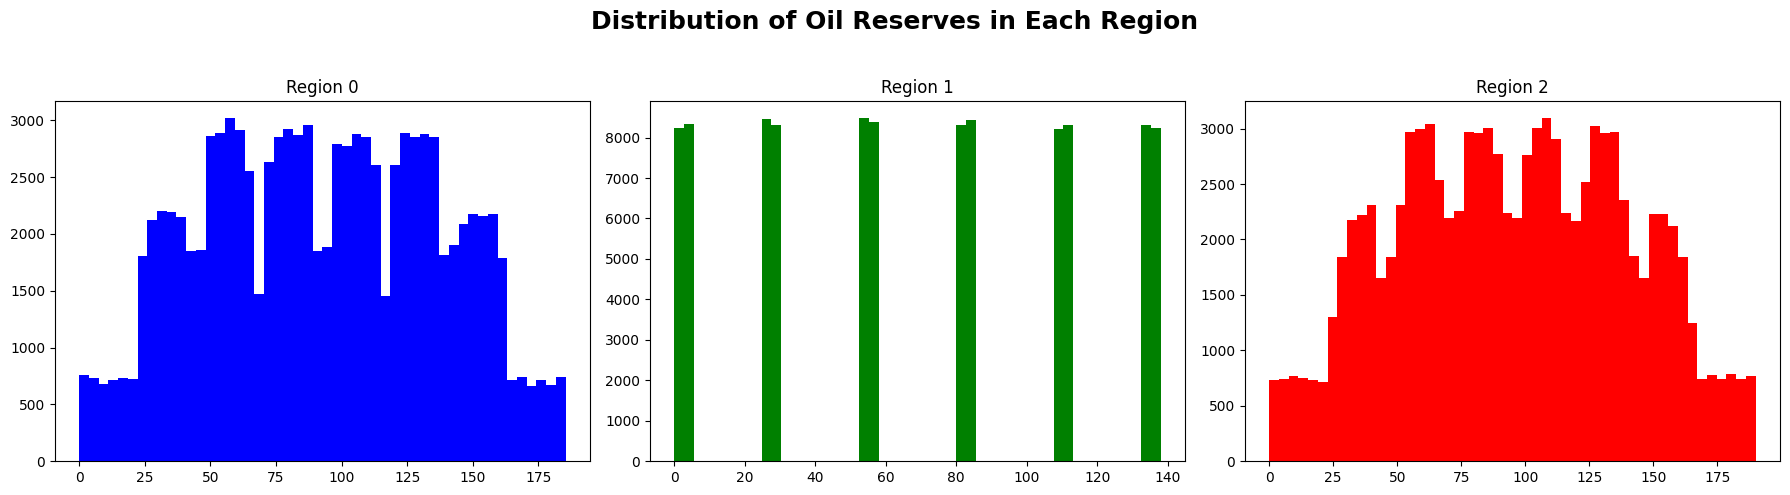

In [5]:
#  Plot histograms for each region
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Distribution of Oil Reserves in Each Region', fontsize=18, fontweight='bold')

axes[0].hist(data_region_0['product'], bins=50, color='blue')
axes[0].set_title('Region 0')

axes[1].hist(data_region_1['product'], bins=50, color='green')
axes[1].set_title('Region 1')

axes[2].hist(data_region_2['product'], bins=50, color='red')
axes[2].set_title('Region 2')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Graph Analysis: Distribution of Oil Reserves by Region
**Region 0:**
- The distribution of oil reserves shows a relatively uniform pattern with multiple peaks.
- There are frequent values around 50, 75, 100, 125, and 150 thousand barrels.
- The number of oil wells with these reserve levels ranges from about 500 to over 3000.

**Region 1:**
- The distribution of oil reserves in Region 1 exhibits a highly periodic pattern with distinct peaks at regular intervals.
- Oil reserves are concentrated around 0, 30, 60, 90, 120, and 140 thousand barrels.
- The number of oil wells for these reserve levels is consistently around 8000.
- This periodic pattern suggests that specific reserve levels are significantly more common.

**Region 2:**
- The distribution of oil reserves in Region 2 shows a more complex pattern with multiple peaks.
- Frequent values are observed around 25, 50, 75, 100, 125, and 150 thousand barrels.
- The number of oil wells ranges from about 500 to over 3000, similar to Region 0.

**Uniformity and Variability:** Regions 0 and 2 exhibit a more variable distribution with multiple peaks, indicating variability in oil reserves. Region 1 shows a highly regular and periodic distribution, suggesting specific reserve levels are more common.

---
### Train and Test the Model for Each Region
- Data Splitting: Each dataset was split into training and validation sets with a ratio of 75:25.
- Model Training: A Linear Regression model was trained on the training set.
- Predictions: Predictions were made on the validation set.
- Performance Metrics: The average predicted volume and Root Mean Squared Error (RMSE) were calculated for each region

#### Split and Scale the Data

In [6]:
# The target column is 'product'
TARGET_COLUMN = 'product'

# Define a function to split and scale data
def split_and_scale_data(data, target_column):
    features = data.drop(target_column, axis=1).drop('id', axis=1)
    target = data[target_column]
    X_train, X_valid, y_train, y_valid = train_test_split(features, target, test_size=0.25, random_state=42)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_valid_scaled = scaler.transform(X_valid)
    
    return X_train_scaled, X_valid_scaled, y_train, y_valid

# Split and scale the datasets
X_train_0, X_valid_0, y_train_0, y_valid_0 = split_and_scale_data(data_region_0, TARGET_COLUMN)
X_train_1, X_valid_1, y_train_1, y_valid_1 = split_and_scale_data(data_region_1, TARGET_COLUMN)
X_train_2, X_valid_2, y_train_2, y_valid_2 = split_and_scale_data(data_region_2, TARGET_COLUMN)

#### Train the Model and Make Predictions

In [7]:
# Define a function to train and predict
def train_and_predict(X_train, y_train, X_valid):
    model = LinearRegression()
    model.fit(X_train, y_train)
    predictions = model.predict(X_valid)
    return predictions, model

# Train and predict for each region
predictions_0, model_0 = train_and_predict(X_train_0, y_train_0, X_valid_0)
predictions_1, model_1 = train_and_predict(X_train_1, y_train_1, X_valid_1)
predictions_2, model_2 = train_and_predict(X_train_2, y_train_2, X_valid_2)

#### Save the Predictions and Correct Answers

In [8]:
# Save predictions and actual values
results_0 = pd.DataFrame({'actual': y_valid_0, 'predicted': predictions_0})
results_1 = pd.DataFrame({'actual': y_valid_1, 'predicted': predictions_1})
results_2 = pd.DataFrame({'actual': y_valid_2, 'predicted': predictions_2})

display(results_0.head())
display(results_1.head())
display(results_2.head())

,actual,predicted
33966,119.813252,127.486528
22854,133.296862,116.465831
19449,25.310435,66.041910
9733,65.422491,45.009390
7129,140.851476,124.535557


,actual,predicted
33968,0.000000,1.745635
24612,134.766305,135.730891
42678,134.766305,133.539653
9732,30.132364,28.844517
7129,137.945408,138.037182


,actual,predicted
33968,156.925842,111.540811
24612,31.245818,66.812289
42677,48.478519,70.406921
9732,34.079047,63.118690
7129,138.077543,141.162178


#### Print the Average Volume of Predicted Reserves and Model RMSE

In [9]:
# Calculate and print average volume and RMSE for each region
def calculate_rmse(actual, predicted):
    return np.sqrt(mean_squared_error(actual, predicted))

avg_predicted_volumes = []
rmses = []

for i, (y_valid, predictions) in enumerate([(y_valid_0, predictions_0), (y_valid_1, predictions_1), (y_valid_2, predictions_2)]):
    avg_predicted = predictions.mean()
    rmse = calculate_rmse(y_valid, predictions)
    
    avg_predicted_volumes.append(avg_predicted)
    rmses.append(rmse)
    
    print(f"Region {i} - Avg Predicted Volume: {avg_predicted:.2f}, RMSE: {rmse:.2f}")

Region 0 - Avg Predicted Volume: 92.61, RMSE: 37.69
Region 1 - Avg Predicted Volume: 68.58, RMSE: 0.89
Region 2 - Avg Predicted Volume: 94.93, RMSE: 40.08


#### Interpretation of RMSE Results by Region:

**Region 0 :**
- The RMSE of 37.69 indicates the model's predictions have a relatively large spread around the actual values. This suggests the model has moderate accuracy, but there is still significant variance between predicted and actual values.

**Region 1:**
- The RMSE of 0.89 is very low, indicating that the model's predictions are very close to the actual values. This high accuracy suggests that the model fits the data for Region 1 very well.

**Region 2:**
- The RMSE of 40.08 indicates a relatively large spread around the actual values, similar to Region 0. This suggests that the model has moderate accuracy with significant variance between predicted and actual values.

#### General RMSE Observations:

**Model Performance:**
- The model performs exceptionally well in Region 1 with a very low RMSE, suggesting a strong fit to the data.
- The model's performance in Regions 0 and 2 is less accurate, with higher RMSE values indicating greater variance in predictions.

**Data Characteristics:**
- The low RMSE in Region 1 may be attributed to the distinct, discrete nature of the data, as seen in the histogram. This distinct pattern may be easier for the model to learn and predict accurately.
- Regions 0 and 2 have more continuous distributions with multiple peaks, which might introduce complexity in the data, making it harder for the model to predict accurately.

#### Prepare for profit calculation:
- Calculate the sufficient volume of reserves to avoid losses.
- Compare this with the average volume of reserves in each region.

In [10]:
# Key values for profit calculation
PRICE_PER_UNIT = 4.5 * 1000  # $4500 per thousand barrels
COST_PER_WELL = 100000000 / 200  # $500000 per well
TOP_N_WELLS = 200

# Combine the datasets into a list 
data_regions = [data_region_0, data_region_1, data_region_2]

# Calculate the volume of reserves sufficient for developing a new well without losses
volume_sufficient = COST_PER_WELL / PRICE_PER_UNIT
print(f"Volume of reserves sufficient for developing a new well without losses: {volume_sufficient:.2f}")

# Compare with the average volume of reserves in each region
for i, data_region in enumerate(data_regions):
    avg_volume = data_region['product'].mean()
    print(f"Region {i} - Avg Volume of Reserves: {avg_volume:.2f}")

Volume of reserves sufficient for developing a new well without losses: 111.11
Region 0 - Avg Volume of Reserves: 92.50
Region 1 - Avg Volume of Reserves: 68.82
Region 2 - Avg Volume of Reserves: 95.00


#### Summary and Interpretaton of Potential Profit and Risks:

**Sufficient Volume to Avoid Losses: 111.11 thousand barrels.** This means that any well producing less than this volume will incur a loss.

**Average Volume of Reserves:**

- Region 0: The average volume of reserves is 92.50 thousand barrels, which is below the sufficient volume to avoid losses.
- Region 1: The average volume of reserves is 68.82 thousand barrels, significantly below the sufficient volume to avoid losses.
- Region 2: The average volume of reserves is 95.00 thousand barrels, also below the sufficient volume to avoid losses.

**Implications:**
- All three regions have average reserve volumes below the threshold needed to avoid losses. This suggests that, on average, wells in these regions are not profitable based on the current cost and revenue structure.
- Region 1: Has the lowest average volume of reserves, making it the least likely to meet the profitability threshold.
- Regions 0 and 2: Have closer average volumes to the sufficient volume but are still below the threshold, indicating potential risk in profitability.

---
### Calculate Profit from Selected Wells
- Select the top 200 wells based on model predictions.
- Calculate the total volume and profit for these wells.
- Suggest the best region based on expected profit.

#### Define the Profit Function 

In [11]:
# Function to calculate profit from selected oil wells
def calculate_profit_from_wells(data, top_n, price_per_unit=PRICE_PER_UNIT, cost_per_well=COST_PER_WELL):
    top_wells = data.nlargest(top_n, 'predicted')
    
    # Summarize the target volume of reserves
    total_volume = top_wells['actual'].sum()
    
    # Calculate profit
    revenue = total_volume * price_per_unit
    cost = top_n * cost_per_well
    profit = revenue - cost
    return total_volume, profit

#### Calculate Profit for Each Region

In [12]:
# Calculate profit for each region
profits = []
total_volumes = []

for i, result in enumerate([results_0, results_1, results_2]):
    total_volume, profit = calculate_profit_from_wells(result, TOP_N_WELLS)
    total_volumes.append(total_volume)
    profits.append(profit)
    print(f"Region {i} - Total Volume: {total_volume:.2f}, Profit: ${profit:.2f}")

# Provide findings and suggest a region
best_region = np.argmax(profits)
print(f"\nThe best region for oil wells' development is Region {best_region} with an expected profit of ${profits[best_region]:.2f}.")

Region 0 - Total Volume: 29930.07, Profit: $34685297.87
Region 1 - Total Volume: 27589.08, Profit: $24150866.97
Region 2 - Total Volume: 27548.03, Profit: $23966130.01

The best region for oil wells' development is Region 0 with an expected profit of $34685297.87.


---
### Calculate Risks and Profit for Each Region Using Bootstrapping:

#### Use the bootstrapping technique with 1000 samples to find the distribution of profit

In [13]:
# Bootstrapping technique to calculate profits 
def bootstrap_profit(data, n_samples=1000, sample_size=500, top_n=TOP_N_WELLS, price_per_unit=PRICE_PER_UNIT, cost_per_well=COST_PER_WELL, random_seed=42):
    np.random.seed(random_seed)  # Set the random seed
    profits = []
    for _ in range(n_samples):
        sample = data.sample(n=sample_size, replace=True)
        _, profit = calculate_profit_from_wells(sample, top_n, price_per_unit, cost_per_well)
        profits.append(profit)
    return np.array(profits)

#### Find average profit, 95% confidence interval and risk of losses:

In [14]:
# Function to calculate average profit sats
def calculate_statistics(profits, confidence_level=0.95):
    avg_profit = np.mean(profits)
    lower_percentile = (1 - confidence_level) / 2 * 100
    upper_percentile = (1 + confidence_level) / 2 * 100
    conf_interval = np.percentile(profits, [lower_percentile, upper_percentile])
    risk_of_loss = (profits < 0).mean() * 100  
    return avg_profit, conf_interval, risk_of_loss

# Process each region
results = []
bootstrap_profits = []

for data_region in data_regions:
    # Split and scale data
    X_train, X_valid, y_train, y_valid = split_and_scale_data(data_region, 'product')
    # Train and predict
    predictions, model = train_and_predict(X_train, y_train, X_valid)
    # Save predictions and actual values
    result = pd.DataFrame({'actual': y_valid, 'predicted': predictions})
    results.append(result)
    # Calculate profits using bootstrapping
    profits = bootstrap_profit(result)  
    bootstrap_profits.append(profits)

# Calculate statistics and financial risks for each region and print the results
region_stats = []
for i, profits in enumerate(bootstrap_profits):
    avg_profit, conf_interval, risk_of_loss = calculate_statistics(profits)
    region_stats.append((avg_profit, conf_interval, risk_of_loss))
    print(f"Region {i} - Average Profit: ${avg_profit:.2f}, 95% Confidence Interval: (${conf_interval[0]:.2f}, ${conf_interval[1]:.2f}), Risk of Loss: {risk_of_loss:.2f}%")

Region 0 - Average Profit: $4035720.64, 95% Confidence Interval: ($-1376900.03, $9028483.11), Risk of Loss: 5.90%
Region 1 - Average Profit: $4302083.52, 95% Confidence Interval: ($430525.20, $8473134.67), Risk of Loss: 1.60%
Region 2 - Average Profit: $3842144.29, 95% Confidence Interval: ($-1275898.77, $9101344.40), Risk of Loss: 8.00%


#### Provide findings: suggest a region for development of oil wells and justify the choice:

In [15]:
# Filter regions with risk of loss lower than 2.5%
filtered_region_stats = [(i, stats) for i, stats in enumerate(region_stats) if stats[2] < 2.5]


# Provide findings and suggest a region
#best_region = np.argmax([stat[0] for stat in region_stats])
#print(f"\nThe best region for oil wells' development is Region {best_region} with an expected profit of ${region_stats[best_region][0]:.2f}.")

# Suggest the best region for development
if filtered_region_stats:
    best_region = max(filtered_region_stats, key=lambda x: x[1][0])
    print(f"\nThe best region for oil wells' development is Region {best_region[0]} with an expected profit of ${best_region[1][0]:.2f}.")
else:
    print("\nNo region meets the risk of loss criteria.")  


The best region for oil wells' development is Region 1 with an expected profit of $4302083.52.


#### Suggesting a Region for Development:

**Region 1** is suggested for the development of oil wells based on the following results:

- Risk of Loss: Region 1 has a risk of loss of 1.60%, which is the only region below the threshold of 2.5%.
- Profit: While Region 1 doesn't have the highest average profit, its risk of loss is lower compared to other regions, making it a safer investment according to the criteria.

#### Plot Profit Distributions

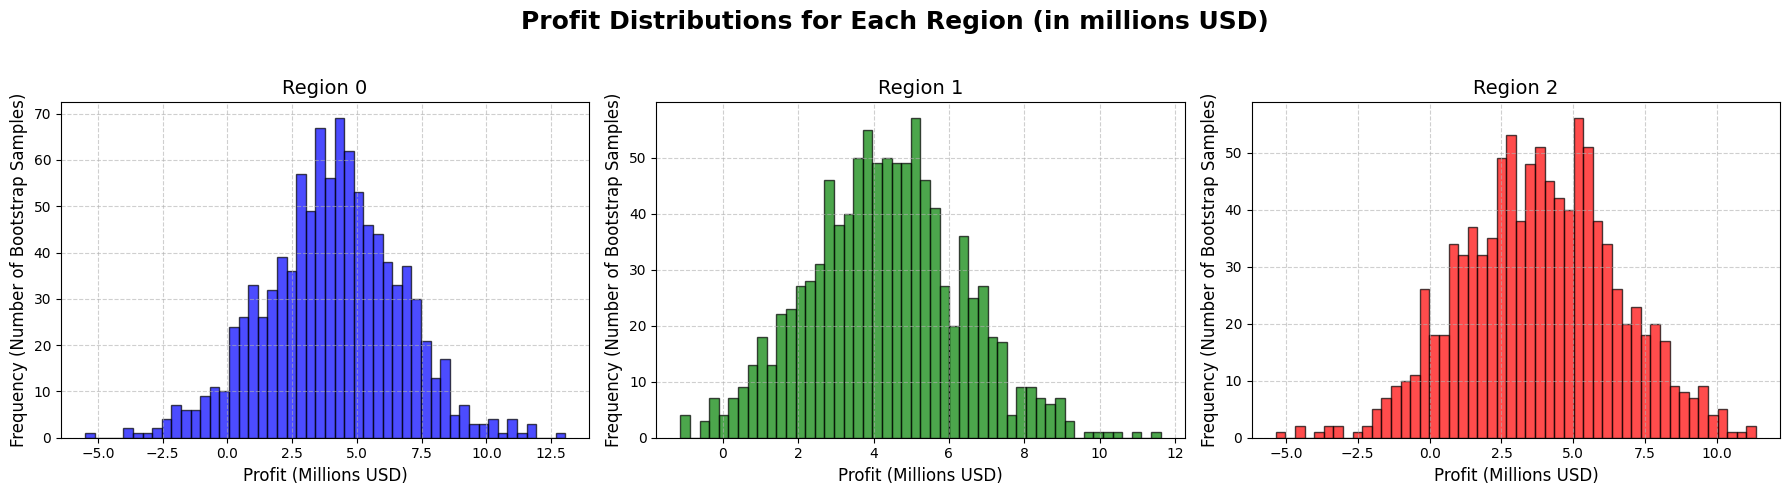

In [16]:
# Plot profit distributions for each region
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)
fig.suptitle('Profit Distributions for Each Region (in millions USD)', fontsize=18, fontweight='bold')

# Scale profits to millions
bootstrap_profits_millions = [profits / 1e6 for profits in bootstrap_profits]

# Define colors
colors = ['blue', 'green', 'red']

# Titles for each region
titles = ['Region 0', 'Region 1', 'Region 2']

# Plot each regions profit distribution
for i, ax in enumerate(axes):
    ax.hist(bootstrap_profits_millions[i], bins=50, color=colors[i], alpha=0.7, edgecolor='black')
    ax.set_title(titles[i], fontsize=14)
    ax.set_xlabel('Profit (Millions USD)', fontsize=12)
    ax.set_ylabel('Frequency (Number of Bootstrap Samples)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.6)

# Adjust layout for better fit
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

#### Graph Analysis: Profit Distributions by Region (Bootsrap Sampling)
- The histograms show that Region 1 has a lower frequency of negative profits compared to Regions 0 and 2, suggesting a relatively lower risk of loss. This aligns with the calculated risk of loss at 1.60%, which is the only risk of loss calculated below the threshold.
- Regions 0 and 2 show significant variability in profit outcomes with wider distributions and substantial risks of negative profits.

---
# Conclusions and Final Recommendations:

**Sufficient Volume to Avoid Losses:**
- Threshold: 111.11 thousand barrels. Any well producing less than this volume will incur a loss.

#### Total Volume and Profit Analysis
**Region 0:** 
- Total Volume: 29,930.07 barrels
- Profit: &dollar;34,685,297.87 
- Average Profit: &dollar;4,035,720.64 
- 95% Confidence Interval: -\\$1,376,900.03 - \\$9,028,483.11
- Risk of Loss: 5.90%

**Region 1:**
- Total Volume: 27,589.08 barrels
- Profit: &dollar;24,150,866.97
- Average Profit: &dollar;4,302,083.52
- 95% Confidence Interval: \\$430,525.20 - \\$8,473,134.67
- Risk of Loss: 1.60%

**Region 2:**
- Total Volume: 27,548.03 barrels
- Profit: &dollar;23,966,130.01
- Average Profit: &dollar;3,842,144.29
- 95% Confidence Interval: -\\$1,275,898.77 - \\$9,101,344.40
- Risk of Loss: 8.00%

#### Final Recommendations: 
**Region Selection:**
- Based on the bootstrap samples, Region 1 has the lowest risk of loss at 1.30%, which is below the threshold of 2.5%. This makes it a safer investment compared to Regions 0 and 2, both of which have higher risks of loss at 5.90% and 8.00%, respectively.
- While Region 1 does not have the highest average profit, it is the safest investment due to its significantly lower risk of loss compared to the other regions.
- Therefore, **Region 1** is recommended for oil well development based on the combination of its lower risk and consistent profitability. This ensures a strategic balance between minimizing risk and achieving reliable returns.
---

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c1e8aaa2-86aa-404a-b687-fae09fa91ce9' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>